In [10]:
import roadrunner
import numpy as np
import matplotlib.pyplot as plt

# Load the SBML model
raw_rr = roadrunner.RoadRunner("NFkBJEI.xml")

# Promote all local parameters to global parameters
promoted_sbml = raw_rr.getParamPromotedSBML(raw_rr.getSBML())

# Create a new RoadRunner instance with the modified SBML
r = roadrunner.RoadRunner(promoted_sbml)

# Print all global parameters to verify promotion
print(r.model.getGlobalParameterIds())

['A20_feedback_strength', 'Activation_k1', 'NFkB_Import_k_import', 'A20_production_k1', 'A20_degradation_k1', 'NFkB_Export_k1', 'Output_production_k1', 'CYLD_production_k1', 'CYLD_degradation_k1', 'CYLD_inhibition_k_cyld', 'Output_degradation_k1']


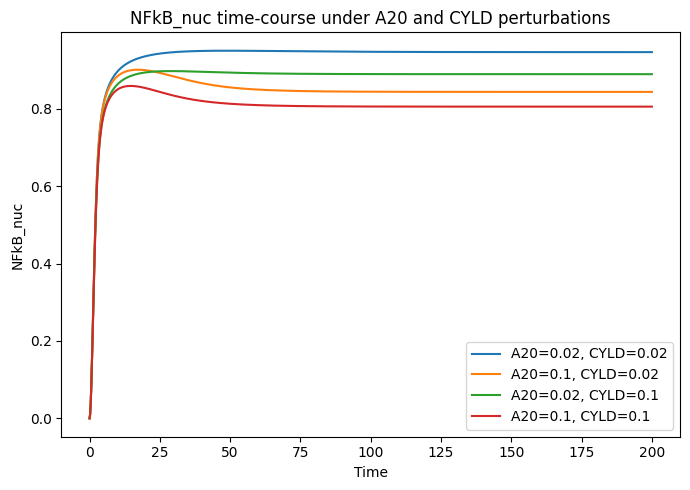

In [11]:
from cProfile import label


r.timeCourseSelections = ["time", "NFkB_nuc", "IKK_active", "A20", "CYLD"]

A20_PARAM = "A20_feedback_strength"
CYLD_PARAM = "CYLD_inhibition_k_cyld" 

BASE_A20 = r[A20_PARAM]
BASE_CYLD = r[CYLD_PARAM]

def simulate_condition(label, a20_value=None, cyld_value=None, t_end=200.0, n_points=1001):
    """
    Runs a single time-course simulation after seting A20/CYLD parameters
    Returns label, time, NFkB_nuc
    """

    r.resetToOrigin()

    # Always start from baseline values first (important for multiple runs)
    r[A20_PARAM] = BASE_A20
    r[CYLD_PARAM] = BASE_CYLD  

    if a20_value is not None:
        r[A20_PARAM] = a20_value
    if cyld_value is not None:
        r[CYLD_PARAM] = cyld_value

    result = r.simulate(0, t_end, n_points)
    cols = r.timeCourseSelections

    t = result[:, cols.index("time")]   
    nfkb_nuc = result[:, cols.index("NFkB_nuc")]  
    r.resetToOrigin() # Reset to baseline before returning so next run starts from baseline
    return label, t, nfkb_nuc

# Choose fold changes (edit these)
A20_FOLD = 5.0
CYLD_FOLD = 5.0

conditions = [
    ("A20=" + str(BASE_A20) + ", CYLD=" + str(BASE_CYLD), BASE_A20, BASE_CYLD),
    ("A20=" + str(BASE_A20 * A20_FOLD) + ", CYLD=" + str(BASE_CYLD), BASE_A20 * A20_FOLD, BASE_CYLD),
    ("A20=" + str(BASE_A20) + ", CYLD=" + str(BASE_CYLD * CYLD_FOLD), BASE_A20, BASE_CYLD * CYLD_FOLD),
    ("A20=" + str(BASE_A20 * A20_FOLD) + ", CYLD=" + str(BASE_CYLD * CYLD_FOLD), BASE_A20 * A20_FOLD, BASE_CYLD * CYLD_FOLD),
]

plt.figure(figsize=(7,5))
for label, a20v, cyldv in conditions:
    lbl, t, y = simulate_condition(label, a20_value=a20v, cyld_value=cyldv)
    plt.plot(t, y, label=lbl)

plt.xlabel("Time")
plt.ylabel("NFkB_nuc")  # Normal distribution so no unit
plt.title("NFkB_nuc time-course under A20 and CYLD perturbations")
plt.legend()
plt.tight_layout()
plt.show()


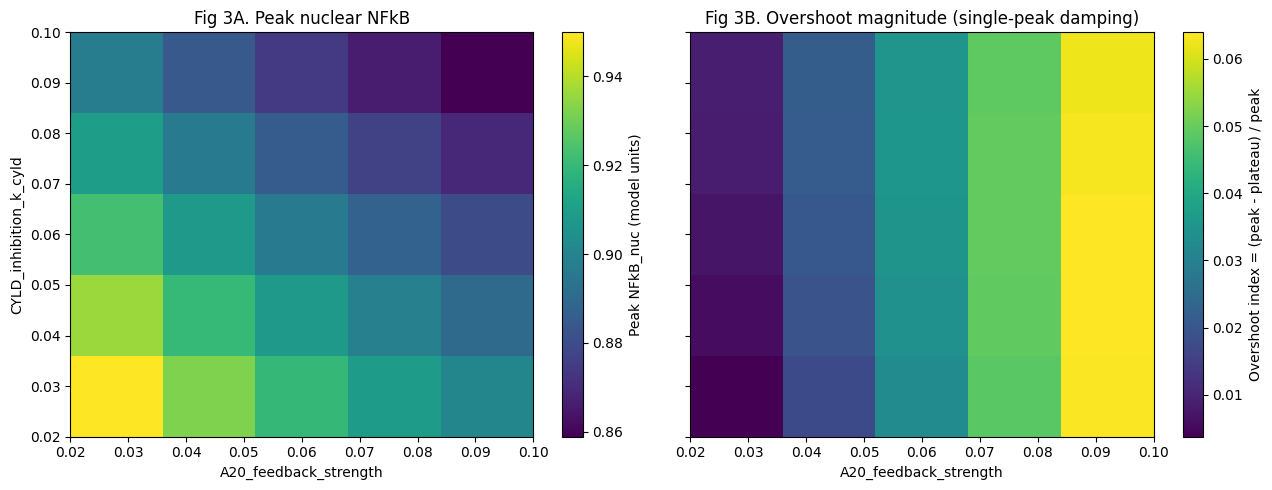

In [8]:
# Simulation Settings

T_END = 200.0  # Simulation of end time
N_PTS = 1001 # Number of time points in simulation 
EPS = 1e-9 # Espilon to avoid division by zero
PLATEAU_FRAC = 0.10 # Last 10% of points used to estimate plateau

r.timeCourseSelections = ["time", "NFkB_nuc"] # Select outputs for time-course simulation

def run_metrics(a20_value, cyld_value):
    """ 
    Run one simulation and return:
        peak, plateau, plateau_ratio, overshoot_index
    plateau is the mean of last PLATEAU_FRAC of the time-course
    """
    r.resetToOrigin()
    r[A20_PARAM] = float(a20_value)
    r[CYLD_PARAM] = float(cyld_value)

    out = r.simulate(0, T_END, N_PTS)
    cols = r.timeCourseSelections

    y = out[:, cols.index("NFkB_nuc")]

    peak = float(np.max(y)) 

    # Plateau as the mean of the last fracion of the curve (more rubust than y[-1])
    tail = y[int((1 - PLATEAU_FRAC) * len(y)) :]
    plateau = float(np.mean(tail))

    plateau_ratio = plateau / (peak + EPS)  # Sustained fraction of peak
    overshoot_index = (peak - plateau) / (peak + EPS)  # 0 = monotonic, >0 = overshoot
   
    return peak, plateau, plateau_ratio, overshoot_index

# Define scan grid
A20_vals = np.array([0.02, 0.04, 0.06, 0.08, 0.10])
CYLD_vals = np.array([0.02, 0.04, 0.06, 0.08, 0.10])

peak_map = np.zeros((len(CYLD_vals), len(A20_vals)))
overshoot_map = np.zeros((len(CYLD_vals), len(A20_vals)))

# Main scan
for i, cy in enumerate(CYLD_vals):
    for j, a20 in enumerate(A20_vals):
        peak, plateau, plateau_ratio, overshoot_index = run_metrics(a20, cy)
        peak_map[i, j] = peak
        overshoot_map[i, j] = overshoot_index

# Plot
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey = True)

# Panel A: Peak heat map
image1 = axes[0].imshow(
    peak_map,
    origin = "lower",
    aspect = "auto",
    extent = [A20_vals.min(), A20_vals.max(), CYLD_vals.min(), CYLD_vals.max()],
    interpolation = "nearest",
)
cbar1 = fig.colorbar(image1, ax=axes[0])
cbar1.set_label("Peak NFkB_nuc (model units)")

axes[0].set_xlabel("A20_feedback_strength")
axes[0].set_ylabel("CYLD_inhibition_k_cyld")
axes[0].set_title("Fig 3A. Peak nuclear NFkB")

# Panel B: Overshoot Index
image2 = axes[1].imshow(
    overshoot_map,
    origin = "lower",
    aspect = "auto",
    extent = [A20_vals.min(), A20_vals.max(), CYLD_vals.min(), CYLD_vals.max()],
    interpolation = "nearest",
)
cbar2 = fig.colorbar(image2, ax=axes[1])
cbar2.set_label("Overshoot index = (peak - plateau) / peak")

axes[1].set_xlabel("A20_feedback_strength")
axes[1].set_title("Fig 3B. Overshoot magnitude (single-peak damping)")

plt.tight_layout()
plt.show()

In [4]:
print (r["Activation_k1"])# Set to baseline value

0.1


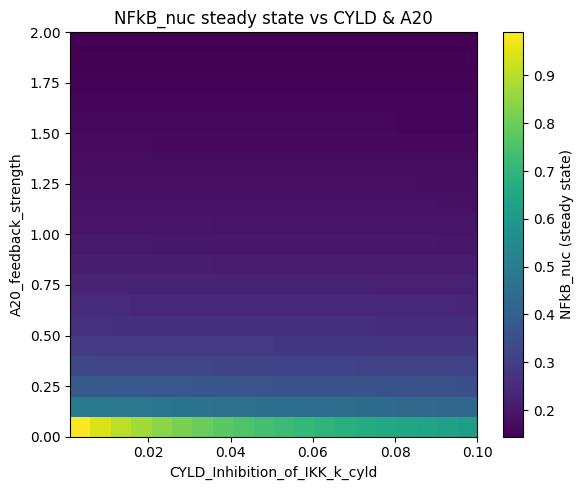

In [5]:
# 2D scan over (k_cyld, A20_feedback_strength)

def scan_2d(param_x, param_y, x_vals, y_vals, observable="NFkB_nuc"):
    """
    Returns matrix Matrix with shape (len(y-vals), len(x_vals))
    where Matrix[j, i] is the observable steady state at 
    param_x = x_vals[i], param_y = y_vals[j]
    """

    Matrix = np.full((len(y_vals), len(x_vals)), np.nan)

    for j, vy in enumerate(y_vals):
        for i, vx in enumerate(x_vals):
            r.resetToOrigin()
            r[param_x] = vx
            r[param_y] = vy
            r["Activation_k1"] = 0.01  # Set to baseline value
            try:
                r.steadyState()
                Matrix[j, i] = r[observable]
            except:
                Matrix[j, i] = np.nan

    return Matrix

# Define ranges
k_vals = np.linspace(0.001, 0.1, 20)  # k_cyld range (avoid 0 to prevent crazy IKK)
a20_vals = np.linspace(0.0, 2.0, 20)  # A20 feedback strength range

NFkB_heat = scan_2d(
    "CYLD_inhibition_k_cyld",
    "A20_feedback_strength",
    k_vals,
    a20_vals,
    observable="NFkB_nuc",
)

# Plot heatmap
plt.figure(figsize=(6,5))
im = plt.imshow(
    NFkB_heat,
    origin="lower",
    aspect="auto",
    extent=[k_vals[0], k_vals[-1], a20_vals[0], a20_vals[-1]]
)
plt.colorbar(im, label="NFkB_nuc (steady state)")
plt.xlabel("CYLD_Inhibition_of_IKK_k_cyld")
plt.ylabel("A20_feedback_strength")
plt.title("NFkB_nuc steady state vs CYLD & A20")
plt.tight_layout()
plt.show()


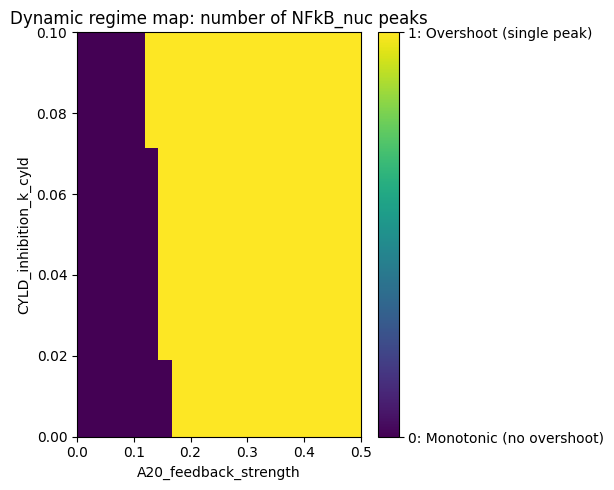

In [6]:
A20_PARAM = "A20_feedback_strength"
CYLD_PARAM = "CYLD_inhibition_k_cyld"
NFKB_SPEC = "NFkB_nuc"

def simulate_step(a20_strength, k_cyld, t_end = 300.0, n_points = 1501, selections = ("time", NFKB_SPEC)):
    """ Just sets A20 and CYLD, then runs a time course """
    r.resetToOrigin()
    r[A20_PARAM] = a20_strength
    r[CYLD_PARAM] = k_cyld

    result = r.simulate(0, t_end, n_points, list(selections))
    return result

def count_peaks_robust(t, y, min_prom = 0.02, min_sep = 15.0, ignore_before = 2.0):
    """ 
    Count biologically meaningful peaks (overshoot/ oscillations), not solver ripples
    min_prom: minimum prominence (peak - nearby local minimum) to be consdered a real peak
    min_sep: minimum time separation between peaks (same time units as t)
    ignore_before: ignore early transient artifacts before this time
    """

    t = np.asarray(t)
    y = np.asarray(y)

    mask = t >= ignore_before
    t2, y2 = t[mask], y[mask]
    if len(y2) < 3:
        return 0
    
    # Candidate local maxima
    candidate_local_maxima = []
    for i in range(1, len(y2) - 1):
        if y2[i] > y2[i - 1] and y2[i] > y2[i + 1]:
            candidate_local_maxima.append(i)
    if not candidate_local_maxima:
        return 0
        
    # Prominence filter: peak must stand out above local baseline
    prominence = []
    window = max(10, int(0.02 * len(y2)))  # ~2% window (min 10 points)
    for i in candidate_local_maxima:
        lo = max(0, i - window)
        hi = min(len(y2), i + window)
        local_min = np.min(y2[lo:hi])
        prom = y2[i] - local_min
        if prom >= min_prom:
            prominence.append(i)
    if not prominence:
        return 0
    
    # Enforce separation: keep highest peaks, discard others too close in time
    prominence = sorted(prominence, key = lambda i: y2[i], reverse = True) # lambda means an anonymous function
    kept = []
    for i in prominence:
        if all(abs(t2[i] - t2[j]) >= min_sep for j in kept):
            kept.append(i)

    return len(kept)

# Parameter grids for A20 and CYLD
a20_vals = np.linspace(0.0, 0.5, 21)
kcyld_vals = np.linspace(0.0, 0.1, 21)

A20_grid, kCYLD_grid = np.meshgrid(a20_vals, kcyld_vals)   

regime_grid = np.zeros_like(A20_grid, dtype=int)

for i in range(A20_grid.shape[0]):
    for j in range(A20_grid.shape[1]):
        a = A20_grid[i, j]
        k = kCYLD_grid[i, j]
        result = simulate_step(a20_strength = a, k_cyld = k, t_end = 300.0, n_points = 1501, selections = ("time", NFKB_SPEC))
        t = result[:, 0]
        nfkb = result[:, 1]

        baseline = nfkb[0]
        response_amp = np.max(nfkb) - baseline

        if response_amp < 0.02:
            regime = 0   # No response
        else:
            peak = count_peaks_robust(t, nfkb, min_prom = 0.02, min_sep = 15.0)
            regime = 1 if peak >= 1 else 2  # 2 = monotonic response

        # Regime labels:
        # 0 = No clear activation
        # 1 = Single pulse
        # 2 = Two or more peaks (oscillatory/ multi-pulse)
        if peak == 0:
            regime = 0
        elif peak == 1:
            regime = 1
        else:
            regime = 2
        
        regime_grid[i, j] = regime

# Plot regime map
fig, ax = plt.subplots(figsize=(6,5)) 

image = ax.imshow(regime_grid, origin = "lower", aspect = "auto", 
                  extent=[a20_vals[0], a20_vals[-1], kcyld_vals[0], kcyld_vals[-1]])

cbar = plt.colorbar(image, ax = ax, ticks = [0, 1])
cbar.ax.set_yticklabels([
    "0: Monotonic (no overshoot)",
    "1: Overshoot (single peak)"
    ])

ax.set_xlabel("A20_feedback_strength")
ax.set_ylabel("CYLD_inhibition_k_cyld")
ax.set_title("Dynamic regime map: number of NFkB_nuc peaks")

plt.tight_layout()
plt.show()


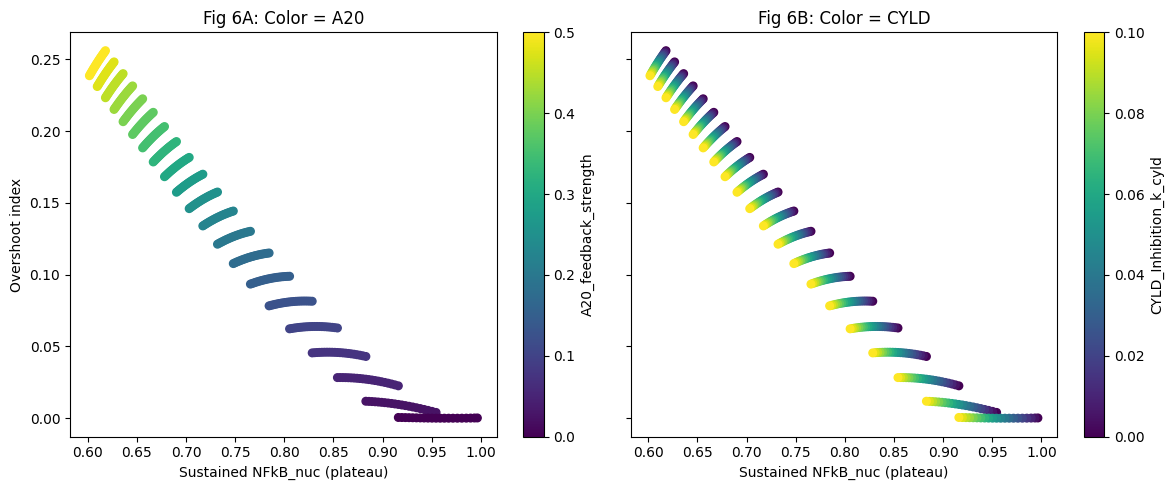

In [9]:
# Metric helper
def metric_plateau_overshoot(t, nfkb, plateau_frac = 0.10):
    peak = float(np.max(nfkb))
    n = len(nfkb)
    tail = nfkb[int((1 - plateau_frac) * n):]
    plateau = float(np.mean(tail))  # Sustained level
    overshoot_index = (peak - plateau) / (peak + EPS)  # 0 = monotonic
    return peak, plateau, overshoot_index

plateaus = []
overshoots = []
a20_vals_pts = []
cyld_vals_pts = []

for i in range(A20_grid.shape[0]):
    for j in range(A20_grid.shape[1]):
        a = A20_grid[i, j]
        k = kCYLD_grid[i, j]

        result = simulate_step(a20_strength = a, k_cyld = k, t_end = 300.0, n_points = 1501, selections = ("time", NFKB_SPEC))
        t = result[:, 0]
        nfkb = result[:, 1]

        peak, plateau, overshoot_idx = metric_plateau_overshoot(t, nfkb, plateau_frac = 0.10)

        plateaus.append(plateau)
        overshoots.append(overshoot_idx)
        a20_vals_pts.append(a)
        cyld_vals_pts.append(k)

plateaus = np.array(plateaus)
overshoots = np.array(overshoots)
a20_vals_pts = np.array(a20_vals_pts)
cyld_vals_pts = np.array(cyld_vals_pts)

# Plot
fig, axes = plt.subplots(1, 2, figsize = (12, 5), sharex = True, sharey = True)

scatter1 = axes[0].scatter(plateaus, overshoots, c = a20_vals_pts, s = 30, cmap="viridis")
plt.colorbar(scatter1, ax = axes[0], label = "A20_feedback_strength")
axes[0].set_title("Fig 6A: Color = A20")
axes[0].set_xlabel("Sustained NFkB_nuc (plateau)")
axes[0].set_ylabel("Overshoot index")

scatter2 = axes[1].scatter(plateaus, overshoots, c = cyld_vals_pts, s = 30, cmap="viridis")
plt.colorbar(scatter2, ax = axes[1], label = "CYLD_Inhibition_k_cyld")
axes[1].set_title("Fig 6B: Color = CYLD")
axes[1].set_xlabel("Sustained NFkB_nuc (plateau)")

plt.tight_layout()
plt.show()